# ProtoNet and Visual Meta-Learning



In this task, you are asked to implement a model which can quickly adapt to new classes and/or tasks with few samples. We will build the architecture inspired from the work: Prototypical Networks ([Snell et al., 2017](https://arxiv.org/pdf/1703.05175.pdf))

* We will focus on the task of few-shot classification where the training and test set have distinct sets of classes.

* You will apply ProtoNet to the CIFAR100 and then test its performance on out-of-distribution data in the SVHN dataset.


The task is divided into four parts that contribute to your total score as follows:
* Dataset Preparation = 1p
* Few-Shot Sampler = 3p
* Prototypical Networks + Advanced Techniques = (1 + 1 + 2 + 1) = 5p
* Domain adaptation in the SVHN experiment = 1p

# Imports

In [ ]:
import os
import numpy as np
import random
import json
from PIL import Image
from collections import defaultdict
from statistics import mean, stdev
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision.datasets import CIFAR100, SVHN
from torchvision import transforms

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "./data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./saved_models"

# Create directory if it doesn't exist
if not os.path.exists(CHECKPOINT_PATH):
    os.makedirs(CHECKPOINT_PATH)


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


# Dataset Preparation (1p)

CIFAR100 has 100 classes and images of size $32\times 32$ pixels. Instead of splitting the training, validation, and test set over examples, we will split them over classes: we will use 80 classes for training, and 10 for validation, and 10 for testing. Our overall goal is to obtain a model that can distinguish between the 10 test classes while seeing very few examples. First, let's load the dataset and visualize some examples.

100%|██████████| 169M/169M [00:07<00:00, 21.4MB/s]


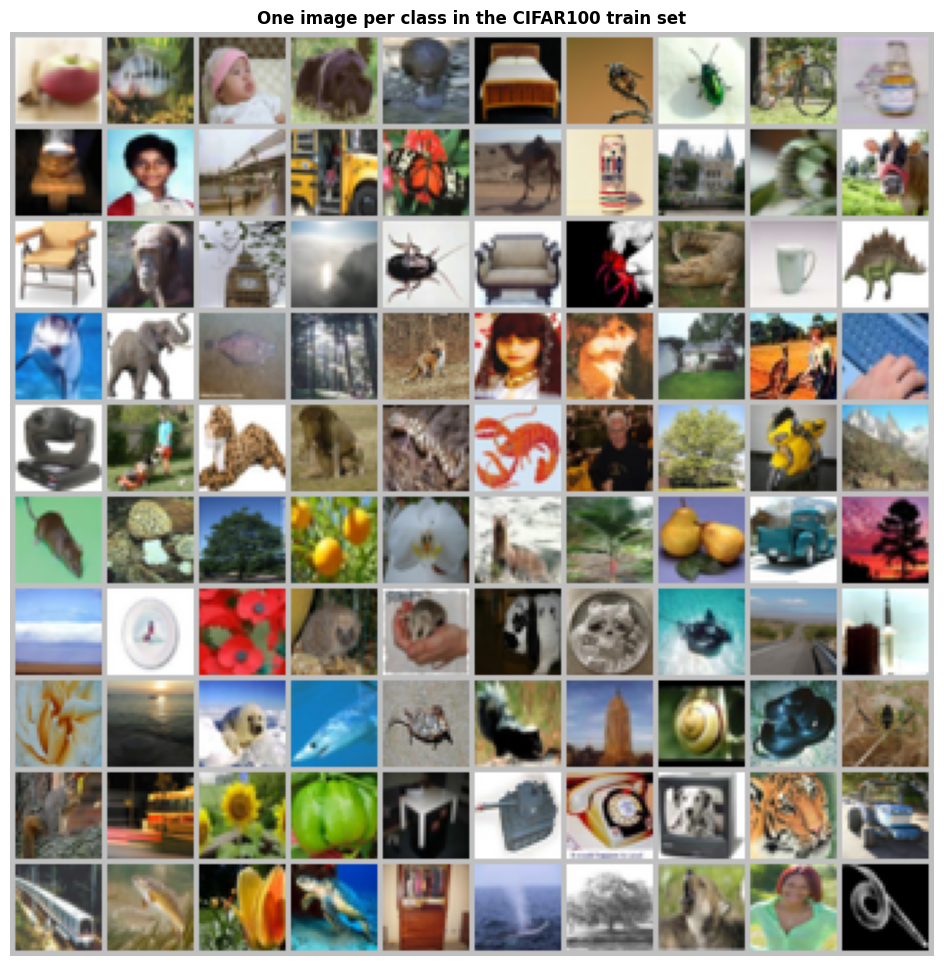

In [ ]:
# Load the CIFAR dataset
CIFAR_train_set = CIFAR100(root=DATASET_PATH, train=True, download=True, transform=transforms.ToTensor())
CIFAR_test_set = CIFAR100(root=DATASET_PATH, train=False, download=True, transform=transforms.ToTensor())

# TODO: Visualise some images in a grid
NUM_CLASSES = 100
train_indices_per_class = {}

for c in range(NUM_CLASSES):
    train_indices_per_class[c] = torch.where(torch.tensor(CIFAR_train_set.targets) == c)[0][0]

train_images = torch.stack([CIFAR_train_set[idx][0] for idx in train_indices_per_class.values()], dim=0)

img_grid = torchvision.utils.make_grid(
    train_images,
    nrow=NUM_CLASSES // 10,
    normalize=True,
    pad_value=0.75
)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(16, 12))

plt.title("One image per class in the CIFAR100 train set", weight='bold')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

Prepare the dataset in the training, validation and test split as mentioned before. The torchvision package gives us the training and test set as two separate dataset objects. Merge the original training and test set, and then create the new train-val-test split

In [ ]:
# Merging original training and test set
CIFAR_all_images = np.concatenate([CIFAR_train_set.data, CIFAR_test_set.data], axis=0)
CIFAR_all_targets = torch.LongTensor(CIFAR_train_set.targets + CIFAR_test_set.targets)

Define our own, dataset class below.
It needs to:

- Take a set of images, labels/targets, and image transformations
- Return the corresponding images and labels element-wise.

In [ ]:
class ImageDataset(data.Dataset):

    def __init__(self, imgs, targets, img_transform=None):
        """
        Inputs:
            imgs - Numpy array of shape [N,32,32,3] containing all images.
            targets - PyTorch array of shape [N] containing all labels.
            img_transform - A torchvision transformation that should be applied
                            to the images before returning. If none, no transformation
                            is applied.
        """
        super().__init__()
        self.img_transform = img_transform
        self.imgs = imgs
        self.targets = targets

    def __getitem__(self, idx):
        # TODO: Fill this
        img = self.imgs[idx]
        target = self.targets[idx]

        if isinstance(img, np.ndarray):
            img = Image.fromarray(img)

        if self.img_transform is not None:
            img = self.img_transform(img)
        else:
            img = transforms.ToTensor()(img)

        return img, target

    def __len__(self):
        # TODO: Fill this
        return self.imgs.shape[0]


Create the class splits. Assign the classes randomly to training, validation and test, and use a 80%-10%-10% split.

In [ ]:
classes = torch.randperm(100)  # Returns random permutation of numbers 0 to 99
train_classes, val_classes, test_classes = classes[:80], classes[80:90], classes[90:]

Classes have quite some variety and some classes might be easier to distinguish than others.

We want to learn the classification of those ten classes from 80 other classes in our training set, and few examples from the actual test classes.


You need to experiment with different number of examples per class.

Create the training, validation and test dataset according to our split above. For this, we create dataset objects of our previously defined class `ImageDataset`.

In [ ]:
def dataset_from_labels(imgs, targets, class_set, img_transform):
    # TODO: Return an ImageDataset object representing a train / val / test set.
    # Its should use the set of all CIFAR images, targets and class split calculated above with the 80-10-10 rule.
    class_mask = (targets[:, None] == class_set[None, :]).any(dim=-1)
    return ImageDataset(imgs=imgs[class_mask], targets=targets[class_mask], img_transform=img_transform)


In [ ]:
# Pre-computed statistics from the new train set
DATA_MEANS = torch.Tensor([0.5183975 , 0.49192241, 0.44651328])
DATA_STD = torch.Tensor([0.26770132, 0.25828985, 0.27961241])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(
                                         DATA_MEANS, DATA_STD)
                                     ])
# For training, try adding some augmentations as well.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(size=(32, 32),
                                                            padding=4,
                                                            padding_mode='reflect'
                                      ),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                      ])

train_set = dataset_from_labels(
    CIFAR_all_images, CIFAR_all_targets, train_classes, img_transform=train_transform)
val_set = dataset_from_labels(
    CIFAR_all_images, CIFAR_all_targets, val_classes, img_transform=test_transform)
test_set = dataset_from_labels(
    CIFAR_all_images, CIFAR_all_targets, test_classes, img_transform=test_transform)

# Few-Shot Sampler (3p)

## The Core Concept

Prototypical Networks simulate few-shot learning during training by:

1. Randomly selecting N classes (N-way classification)
2. Sampling K examples per class for the **support set** (K-shot learning)
3. Sampling additional examples from the same classes for the **query set**

The model learns to classify query examples by comparing them to class prototypes computed from the support set.

## Implementation Task

Complete the `FewShotBatchSampler` class to:
- Select random classes for each episode
- Create support and query sets from these classes
- Ensure proper indexing for the dataloader

This sampler will enable the N-way, K-shot training regime needed for few-shot learning.

**Hint:** Refer to PyTorch's [Sampler documentation](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler) for implementation details. You'll create a custom sampler that controls which data examples are used in each training batch.

In [ ]:
class FewShotBatchSampler(object):

    def __init__(self, dataset_targets, N_way, K_shot, include_query=False, shuffle=True, shuffle_once=False):
        """
        Inputs:
            dataset_targets - PyTorch tensor of the labels from the dataset in the order they occur in it.
            N_way - Number of classes to sample per batch.
            K_shot - Number of examples to sample per class in the batch.
            include_query - If True, returns batch of size N_way*K_shot*2, which
                            can be split into support and query set. Simplifies
                            the implementation of sampling the same classes but
                            distinct examples for support and query set.
            shuffle - If True, examples and classes are newly shuffled in each
                      iteration (for training)
            shuffle_once - If True, examples and classes are shuffled once in
                           the beginning, but kept constant across iterations
                           (for validation)
        """
        super().__init__()
        self.dataset_targets = dataset_targets
        self.N_way = N_way
        self.K_shot = K_shot
        self.shuffle = shuffle
        self.include_query = include_query
        if self.include_query:
            self.K_shot *= 2
        self.batch_size = self.N_way * self.K_shot  # Number of overall images per batch

        # Organize examples by class
        self.classes = torch.unique(self.dataset_targets).tolist()
        self.num_classes = len(self.classes)
        self.indices_per_class = {}
        self.batches_per_class = {}  # Number of K-shot batches that each class can provide
        for c in self.classes:
            self.indices_per_class[c] = torch.where(self.dataset_targets == c)[0]
            self.batches_per_class[c] = self.indices_per_class[c].shape[0] // self.K_shot

        # Create a list of classes from which we select the N classes per batch
        self.iterations = sum(self.batches_per_class.values()) // self.N_way
        self.class_list = [c for c in self.classes for _ in range(self.batches_per_class[c])]
        if shuffle_once or self.shuffle:
            self.shuffle_data()
        else:
            # For testing, we iterate over classes instead of shuffling them
            sort_idxs = [i+p*self.num_classes for i,
                         c in enumerate(self.classes) for p in range(self.batches_per_class[c])]
            self.class_list = np.array(self.class_list)[np.argsort(sort_idxs)].tolist()

    def shuffle_data(self):
        for c in self.classes:
            perm = torch.randperm(self.indices_per_class[c].shape[0])
            self.indices_per_class[c] = self.indices_per_class[c][perm]
        random.shuffle(self.class_list)

    def __iter__(self):
        # Todo: Fill this using the above code and the following directives #
        # Step 1) Shuffle data
        # Step 2) Sample few-shot batches.
        # Step 3) Select N classes for the batch
        # Step 4) For each class, select the next K examples and add them to the batch
        # Step 5) Take into account the self.include_query variable and return support+query set, if True.
        if self.shuffle:
            self.shuffle_data()

        start = defaultdict(int)
        for iteration in range(self.iterations):
            class_batch = self.class_list[iteration * self.N_way:(iteration + 1) * self.N_way]  # N classes for the batch
            batch = []
            for c in class_batch:
                batch.extend(self.indices_per_class[c][start[c]:start[c] + self.K_shot])
                start[c] += self.K_shot

            # Reorder for support/querry
            if self.include_query:
                batch = batch[::2] + batch[1::2]

            yield batch

    def __len__(self):
        return self.iterations

Now, create our intended data loaders by passing an object of `FewShotBatchSampler` as `batch_sampler=...` input to the PyTorch data loader object.

## Configuring Data Loaders

Use a 5-class 4-shot training setting:
- **N-way**: 5 classes per episode
- **K-shot**: 4 examples per class for the support set
- **Total support set size**: 20 images (5 × 4)

This configuration means each support set contains examples from 5 random classes with 4 examples per class. While it's usually best to match the training shots with your test configuration, we're using 4 as a compromise to allow for experimenting with different shot numbers later.

For optimal performance, you could treat the number of training shots as a hyperparameter in a grid search, but 4 shots works well for this exercise.

In [ ]:
N_WAY = 5
K_SHOT = 4
train_data_loader = data.DataLoader(train_set,
                                    batch_sampler=FewShotBatchSampler(train_set.targets,
                                                                      include_query=True,
                                                                      N_way=N_WAY,
                                                                      K_shot=K_SHOT,
                                                                      shuffle=True),
                                    pin_memory=True,
                                    persistent_workers=True,
                                    num_workers=4)
val_data_loader = data.DataLoader(val_set,
                                  batch_sampler=FewShotBatchSampler(val_set.targets,
                                                                    include_query=True,
                                                                    N_way=N_WAY,
                                                                    K_shot=K_SHOT,
                                                                    shuffle=False,
                                                                    shuffle_once=True),
                                  pin_memory=True,
                                  persistent_workers=True,
                                  num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


The sampling of a support and query set should be implemented as sampling method from a support set with twice the number of examples, as shown below:

In [ ]:
def split_batch(imgs, targets):
    support_imgs, query_imgs = imgs.chunk(2, dim=0)
    support_targets, query_targets = targets.chunk(2, dim=0)
    return support_imgs, query_imgs, support_targets, query_targets

Finally, to ensure that our implementation of the data sampling process is correct, we can sample a batch and visualize its support and query set. What we would like to see is that the support and query set have the same classes, but distinct examples.

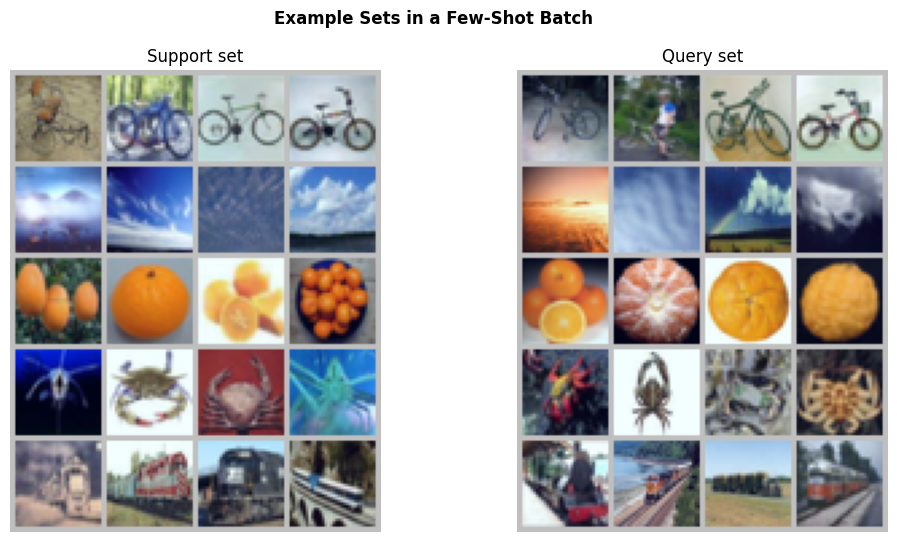

In [ ]:
# Todo: Fill this #
imgs, targets = next(iter(val_data_loader))  # Validation dataset
support_imgs, query_imgs, _, _ = split_batch(imgs, targets)
support_grid = torchvision.utils.make_grid(support_imgs, nrow=K_SHOT, normalize=True, pad_value=0.75)
support_grid = support_grid.permute(1, 2, 0)
query_grid = torchvision.utils.make_grid(query_imgs, nrow=K_SHOT, normalize=True, pad_value=0.75)
query_grid = query_grid.permute(1, 2, 0)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(support_grid)
ax[0].set_title("Support set")
ax[0].axis('off')
ax[1].imshow(query_grid)
ax[1].set_title("Query set")
ax[1].axis('off')
plt.suptitle("Example Sets in a Few-Shot Batch", weight='bold')
plt.show()
plt.close()

# Prototypical Networks

The Prototypical Network, or ProtoNet for short, is a metric-based meta-learning algorithm that operates similarly to the nearest neighbor classification. Metric-based meta-learning methods classify a new example $\mathbf{x}$ based on some distance function $d_{\varphi}$ between $x$ and all elements in the support set. ProtoNets implements this idea with the concept of prototypes in a learned feature space. First, ProtoNet uses an embedding function $f_{\theta}$ to encode each input in the support set into a $L$-dimensional feature vector. Next, for each class $c$, we collect the feature vectors of all examples with label $c$ and average their feature vectors. Formally, we can define this as:

$$\mathbf{v}_c=\frac{1}{|S_c|}\sum_{(\mathbf{x}_i,y_i)\in S_c}f_{\theta}(\mathbf{x}_i)$$

where $S_c$ is the part of the support set $S$ for which $y_i=c$, and $\mathbf{v}_c$ represents the _prototype_ of class $c$. The prototype calculation is visualized below for a 2-dimensional feature space and 3 classes. The colored dots represent encoded support elements with the color-corresponding class labels, and the black dots next to the class label are the averaged prototypes.

protonet_classification.svg
---
Based on these prototypes, we want to classify a new example. Remember that since we want to learn the encoding function $f_{\theta}$, this classification must be differentiable, and hence, we need to define a probability distribution across classes. For this, we will make use of the distance function $d_{\varphi}$: the closer a new example $\mathbf{x}$ is to a prototype $\mathbf{v}_c$, the higher the probability for $\mathbf{x}$ belonging to class $c$. Formally, we can simply use a softmax over the distances of $\mathbf{x}$ to all class prototypes:

$$p(y=c\vert\mathbf{x})=\text{softmax}(-d_{\varphi}(f_{\theta}(\mathbf{x}), \mathbf{v}_c))=\frac{\exp\left(-d_{\varphi}(f_{\theta}(\mathbf{x}), \mathbf{v}_c)\right)}{\sum_{c'\in \mathcal{C}}\exp\left(-d_{\varphi}(f_{\theta}(\mathbf{x}), \mathbf{v}_{c'})\right)}$$

Note that the negative sign is necessary since we want to increase the probability for close-by vectors and have a low probability for distant vectors. We train the network $f_{\theta}$ based on the cross-entropy error of the training query set examples. Thereby, the gradient flows through both the prototypes $\mathbf{v}_c$ and the query set encodings $f_{\theta}(\mathbf{x})$. For the distance function $d_{\varphi}$, we can choose any function as long as it is differentiable concerning both of its inputs. The most common function, which we also use here, is the squared euclidean distance, but feel free to add your own suggestions!

Define the encoder function $f_{\theta}$, for our purposes it will be a DenseNet (use torchvision for this).

You should use common hyperparameters of 64 initial feature channels, add 32 per block, and use a bottleneck size of 64 (i.e. 2 times the growth rate).
We use 4 stages of 6 layers each, which results in overall about 1 million parameters.

Note that the torchvision package assumes that the last layer is used for classification and hence calls its output size `num_classes`.

However, we can instead just use it as the feature space of ProtoNet and choose an arbitrary dimensionality.

In [ ]:
def get_convnet(output_size):
    convnet = torchvision.models.DenseNet(# TODO: Fill this according to the instructions above
                                          num_init_features=64,
                                          growth_rate=32,
                                          bn_size=2,
                                          block_config=(6, 6, 6, 6),
                                          num_classes=output_size
    )
    return convnet

# Advanced Techniques for Robust Few-Shot Learning

We will add two important enhancements to our ProtoNet implementation to boost its robustness and adaptability to new domains:

## CORAL Loss for Feature Alignment (1p)

When facing domain shifts between training and testing distributions, features can exhibit different statistical properties. The CORAL (CORrelation ALignment) loss aligns the second-order statistics (covariance) between support and query features, encouraging domain-invariant representations.

Implementation benefits:
- Reduces the impact of domain shift
- Improves generalization to new domains
- Creates more transferable features

Reference: [Deep CORAL: Correlation Alignment for Deep Domain Adaptation](https://arxiv.org/abs/1607.01719)


In [ ]:
def coral_loss(source: torch.Tensor,
               target: torch.Tensor) -> float:
    """ Function to compute CORrelation ALignment.
    """

    def compute_covariance(x, EPS=1e-8):
        """ Numerically stable way of calculating covariance.
        """
        dimension = x.size(0)
        ones = torch.ones(dimension, 1, device=x.device)
        term1 = x.T @ x
        term2 = (x.T @ ones @ ones.T @ x) / dimension
        return (term1 - term2) / (dimension - 1 + EPS)


    d = source.size(1)
    covariance_source = compute_covariance(source)
    covariance_target = compute_covariance(target)

    return (torch.norm(covariance_source - covariance_target, p='fro') / (2 * d)) ** 2

## Auxiliary Discrimination Branch (1p)

To enhance feature discrimination, we'll add an auxiliary branch that classifies whether features come from the support or query set. This branch:
- Acts as a regularizer for the feature extractor
- Encourages the network to learn domain-aware features
- Provides additional supervision signals during training

You can experiment with the architecture of this branch to find the optimal configuration for your specific few-shot learning task.

In [ ]:
# TODO: Implement the Auxiliary Discrimination Branch inside the ProtoNet class #
class AuxDiscriminationBranch(nn.Module):

    class ResidualBlock(nn.Module):
        """ Helper Class of ResidualBlock beetwen layers of different sizes
        in AuxDiscriminationBranch.
        """
        def __init__(self, dim_in: int, dim_out: int):
            super().__init__()
            self.fc = nn.Linear(dim_in, dim_out)
            self.bn = nn.BatchNorm1d(dim_out)
            self.skip = nn.Identity() if dim_in == dim_out else nn.Linear(dim_in, dim_out)

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            out = self.fc(x)
            out = self.bn(out)
            return out + self.skip(x)

    class SelfAttentionBlock(nn.Module):
        """ Applies self-attention on a [Batch, Dimension] tensor
        by treating it as a sequence of length 1.
        """
        def __init__(self, embed_dim, num_heads):
            super().__init__()
            self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

        def forward(self, x):
            seq = x.unsqueeze(1)
            attn_output, _ = self.attn(seq, seq, seq)
            return attn_output.squeeze(1)


    def __init__(
        self,
        input_dim: int,
        hidden_size: int = None,
        num_layers: int = 2,
        p_dropout: float = 0.5,
        activation: str = "relu",
        use_residuals: bool = False,
        use_attention: bool = False,
        attention_heads: int = 4
    ):
        """
        Args:
            input_dim (int):        Dimensionality of input features.
            hidden_size (int):      Size of each hidden layer (defaults to input_dim // 2).
            num_layers (int):       Number of hidden Linear layers (>=1).
            p_dropout (float):      Dropout probability.
            activation (str):       one of ['relu', 'leaky', 'silu', 'gelu', 'elu']
            use_residuals (bool):   If skip connections should be applied every 2 layers.
            use_attention (bool):   If self-attention should be block after layer 1.
            attention_heads (int):  Number of heads for MultiheadAttention if used.
        """
        super().__init__()
        if hidden_size is None:
            hidden_size = input_dim // 2
        assert num_layers >= 1, "num_layers must be >=1"

        # Choose activation function
        if activation == 'relu':
            Act = nn.ReLU
        elif activation == 'silu':
            Act = nn.SiLU
        elif activation == 'leaky':
            Act = lambda **kw: nn.LeakyReLU(0.05, **kw)
        elif activation =='elu':
            Act = lambda **kw: nn.ELU(0.05, **kw)
        else:
            raise ValueError(f"Unsupported activation={activation}")

        layers = []
        in_dim = input_dim

        for i in range(num_layers):
            layers.append(nn.Linear(in_dim, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(Act(inplace=True))
            layers.append(nn.Dropout(p_dropout))

            # Add attention
            if use_attention and i == 0:
                layers.append(self.SelfAttentionBlock(hidden_size, attention_heads))

            # Add residual block
            if use_residuals and i % 2 == 1:
                layers.append(self.ResidualBlock(hidden_size, hidden_size))

            in_dim = hidden_size

        # Final classification
        layers.append(nn.Linear(hidden_size, 2))
        self.net = nn.Sequential(*layers)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.MultiheadAttention):
                nn.init.xavier_uniform_(m.in_proj_weight)
                if m.in_proj_bias is not None:
                    nn.init.zeros_(m.in_proj_bias)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

Next, implement ProtoNet.
The first step during training is to encode all images in a batch with our network.
Next, we calculate the class prototypes from the support set (function `calculate_prototypes`), and classify the query set examples according to the prototypes (function `classify_feats`).
Keep in mind that we use the data sampling described before, such that the support and query set are stacked together in the batch.
Thus, we use our previously defined function `split_batch` to split them apart.

In [ ]:
class ProtoNet(nn.Module):
    def __init__(self, proto_dim, lr):
        """
        Inputs:
            proto_dim - Dimensionality of prototype feature space
            lr - Learning rate of Adam optimizer
        """
        super(ProtoNet, self).__init__()
        self.proto_dim = proto_dim
        self.lr = lr
        self.model = get_convnet(output_size=proto_dim)
        self.optimizer = optim.AdamW(self.parameters(), lr=lr)
        self.scheduler = optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=[140, 180], gamma=0.1)

        # --- Auxiliary Branch for Discrimination Loss --- #
        # This branch predicts whether a feature comes from the support (0) or query (1) set.
        self.aux_classifier = AuxDiscriminationBranch(input_dim = self.proto_dim,
                                                      hidden_size = self.proto_dim // 2,
                                                      num_layers = 2,
                                                      p_dropout = 0.50,
                                                      activation = 'silu',
                                                      use_residuals = True,
                                                      use_attention = False,
                                                      attention_heads = 8
        )
        self.lambda_aux = 0.50   # Weight for auxiliary loss
        self.lambda_coral = 1.00 # Weight for CORAL loss

    @staticmethod
    def calculate_prototypes(features, targets):
        # TODO: Fill this, remember to average class feature vectors during the calculation of prototypes
        classes, _ = torch.unique(targets).sort()
        prototypes = []
        for c in classes:
            p = features[torch.where(targets == c)[0]].mean(dim=0)
            prototypes.append(p)

        prototypes = torch.stack(prototypes, dim=0)
        return prototypes, classes

    def classify_feats(self, prototypes, classes, feats, targets):
        # TODO: Fill this using squared euclidean as your distance.
        euclidean_distance = torch.pow(prototypes[None, :] - feats[:, None], 2).sum(dim=2)
        predictions = F.log_softmax(-euclidean_distance, dim=1)
        labels = (classes[None, :] == targets[:, None]).long().argmax(dim=-1)
        acc = (predictions.argmax(dim=1) == labels).float().mean()

        return predictions, labels, acc

    def forward(self, imgs, targets):
        features = self.model(imgs)
        return features

    def calculate_loss(self, features, targets):
        # TODO: Fill this
        support_features, query_features, support_targets, query_targets = split_batch(features, targets)
        prototypes, classes = ProtoNet.calculate_prototypes(support_features, support_targets)
        predictions, labels, acc = self.classify_feats(prototypes, classes, query_features, query_targets)
        classification_loss = F.cross_entropy(predictions, labels)

        # Binary labels (0 for support, 1 for query)
        aux_labels = torch.cat([
            torch.zeros(support_features.size(0)),
            torch.ones(query_features.size(0))
        ]).to(features.device)

        all_feats = torch.cat([support_features, query_features])
        aux_preds = self.aux_classifier(all_feats)
        aux_loss = F.binary_cross_entropy_with_logits(aux_preds[:, 1], aux_labels)

        coral_loss_val = coral_loss(support_features, query_features)

        # Combine losses with weighted factors
        total_loss = (classification_loss
                    + self.lambda_aux * aux_loss
                    + self.lambda_coral * coral_loss_val)

        return total_loss, acc

### Training and Validation (2p)

We recommend training for about 20 epochs and with a 64-dimensional feature space.

In [ ]:
def train_model(model_class, train_loader, val_loader, proto_dim, lr, max_epochs=20, **kwargs):
    # Initialize the model
    model = model_class(proto_dim=proto_dim, lr=lr)
    model.to(device)

    # Train the model, validate every epoch and keep the best model.
    # Todo: Fill this #
    def clear_dataloader_workers(loader):
        iterator = getattr(loader, "_iterator", None)
        if iterator is not None and hasattr(iterator, "_shutdown_workers"):
            iterator._shutdown_workers()
            loader._iterator = None


    optimizer = model.optimizer
    scheduler = model.scheduler
    best_val_acc = 0.0
    protonet_result_file = os.path.join(CHECKPOINT_PATH, "best_protonet.pth")
    try:
        retrain = kwargs['kwargs'].get("load_model", False)
    except:
        retrain = False
        print("Start Training")

    if retrain:
        if os.path.exists(protonet_result_file):
            model.load_state_dict(torch.load(protonet_result_file))
            print("Loaded pre-trained model for retrainin")
    else:
        print("No pre-trained model. Training from scratch.")

    # Training loop
    for epoch in range(max_epochs):
        model.train()
        train_loss, train_acc, train_total = 0.0, 0.0, 0

        # Training epoch per batches
        for batch in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
            imgs, targets = batch
            imgs, targets = imgs.to(device), targets.to(device)
            optimizer.zero_grad()
            features = model(imgs, targets)
            loss, acc = model.calculate_loss(features, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * imgs.size(0)
            train_acc += acc.item() * imgs.size(0)
            train_total += imgs.size(0)

        avg_train_loss = train_loss / train_total
        avg_train_acc = train_acc / train_total

        # Validation
        model.eval()
        val_loss, val_acc, val_total = 0.0, 0.0, 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Val Epoch {epoch+1}"):
                imgs, targets = batch
                imgs, targets = imgs.to(device), targets.to(device)
                features = model(imgs, targets)
                loss, acc = model.calculate_loss(features, targets)

                val_loss += loss.item() * imgs.size(0)
                val_acc += acc.item() * imgs.size(0)
                val_total += imgs.size(0)

        avg_val_loss = val_loss / val_total
        avg_val_acc = val_acc / val_total

        # Update scheduler
        if scheduler is not None:
            scheduler.step()

        # Save best model
        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc
            torch.save(model.state_dict(), protonet_result_file)
            print(f"New best model saved with Accuracy on Validation Dataset: {best_val_acc:.4f}")

        # Progress logging
        print(f"Epoch {epoch+1}/{max_epochs}: "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}"
        )

        # Clear memory
        clear_dataloader_workers(train_loader)
        clear_dataloader_workers(val_loader)

    # Load best model on validation dataset after training
    model.load_state_dict(torch.load(protonet_result_file))
    return model

In [ ]:
protonet_model = train_model(ProtoNet,
                             proto_dim=64,
                             lr=2e-4,
                             train_loader=train_data_loader,
                             val_loader=val_data_loader)

Start Training
No pre-trained model. Training from scratch.


Train Epoch 1:   0%|          | 0/1200 [00:00<?, ?it/s]

Val Epoch 1:   0%|          | 0/150 [00:00<?, ?it/s]

New best model saved with Accuracy on Validation Dataset: 0.5663
Epoch 1/20: Train Loss: 1.9018, Train Acc: 0.3931 | Val Loss: 1.4232, Val Acc: 0.5663


Train Epoch 2:   0%|          | 0/1200 [00:00<?, ?it/s]

Val Epoch 2:   0%|          | 0/150 [00:00<?, ?it/s]

New best model saved with Accuracy on Validation Dataset: 0.6013
Epoch 2/20: Train Loss: 1.7477, Train Acc: 0.4562 | Val Loss: 1.3467, Val Acc: 0.6013


Train Epoch 3:   0%|          | 0/1200 [00:00<?, ?it/s]

Val Epoch 3:   0%|          | 0/150 [00:00<?, ?it/s]

New best model saved with Accuracy on Validation Dataset: 0.6173
Epoch 3/20: Train Loss: 1.6891, Train Acc: 0.4811 | Val Loss: 1.3852, Val Acc: 0.6173


Train Epoch 4:   0%|          | 0/1200 [00:00<?, ?it/s]

Val Epoch 4:   0%|          | 0/150 [00:00<?, ?it/s]

New best model saved with Accuracy on Validation Dataset: 0.6297
Epoch 4/20: Train Loss: 1.6406, Train Acc: 0.5050 | Val Loss: 1.3003, Val Acc: 0.6297


Train Epoch 5:   0%|          | 0/1200 [00:00<?, ?it/s]

Val Epoch 5:   0%|          | 0/150 [00:00<?, ?it/s]

New best model saved with Accuracy on Validation Dataset: 0.6433
Epoch 5/20: Train Loss: 1.5979, Train Acc: 0.5315 | Val Loss: 1.2795, Val Acc: 0.6433


Train Epoch 6:   0%|          | 0/1200 [00:00<?, ?it/s]

Val Epoch 6:   0%|          | 0/150 [00:00<?, ?it/s]

New best model saved with Accuracy on Validation Dataset: 0.6513
Epoch 6/20: Train Loss: 1.5479, Train Acc: 0.5483 | Val Loss: 1.2530, Val Acc: 0.6513


Train Epoch 7:   0%|          | 0/1200 [00:00<?, ?it/s]

Val Epoch 7:   0%|          | 0/150 [00:00<?, ?it/s]

New best model saved with Accuracy on Validation Dataset: 0.6677
Epoch 7/20: Train Loss: 1.5188, Train Acc: 0.5613 | Val Loss: 1.2208, Val Acc: 0.6677


Train Epoch 8:   0%|          | 0/1200 [00:00<?, ?it/s]

Val Epoch 8:   0%|          | 0/150 [00:00<?, ?it/s]

New best model saved with Accuracy on Validation Dataset: 0.6833
Epoch 8/20: Train Loss: 1.4746, Train Acc: 0.5820 | Val Loss: 1.1798, Val Acc: 0.6833


Train Epoch 9:   0%|          | 0/1200 [00:00<?, ?it/s]

Val Epoch 9:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 9/20: Train Loss: 1.4490, Train Acc: 0.5888 | Val Loss: 1.3040, Val Acc: 0.6673


Train Epoch 10:   0%|          | 0/1200 [00:00<?, ?it/s]

Val Epoch 10:   0%|          | 0/150 [00:00<?, ?it/s]

New best model saved with Accuracy on Validation Dataset: 0.7050
Epoch 10/20: Train Loss: 1.4312, Train Acc: 0.5973 | Val Loss: 1.0951, Val Acc: 0.7050


Train Epoch 11:   0%|          | 0/1200 [00:00<?, ?it/s]

Val Epoch 11:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 11/20: Train Loss: 1.4003, Train Acc: 0.6128 | Val Loss: 1.1381, Val Acc: 0.6977


Train Epoch 12:   0%|          | 0/1200 [00:00<?, ?it/s]

Val Epoch 12:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 12/20: Train Loss: 1.3778, Train Acc: 0.6216 | Val Loss: 1.2309, Val Acc: 0.6893


Train Epoch 13:   0%|          | 0/1200 [00:00<?, ?it/s]

Val Epoch 13:   0%|          | 0/150 [00:00<?, ?it/s]

New best model saved with Accuracy on Validation Dataset: 0.7130
Epoch 13/20: Train Loss: 1.3377, Train Acc: 0.6358 | Val Loss: 1.1312, Val Acc: 0.7130


Train Epoch 14:   0%|          | 0/1200 [00:00<?, ?it/s]

Val Epoch 14:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 14/20: Train Loss: 1.3235, Train Acc: 0.6443 | Val Loss: 1.2073, Val Acc: 0.6947


Train Epoch 15:   0%|          | 0/1200 [00:00<?, ?it/s]

Val Epoch 15:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 15/20: Train Loss: 1.3065, Train Acc: 0.6509 | Val Loss: 1.1656, Val Acc: 0.7060


Train Epoch 16:   0%|          | 0/1200 [00:00<?, ?it/s]

Val Epoch 16:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 16/20: Train Loss: 1.2849, Train Acc: 0.6595 | Val Loss: 1.1701, Val Acc: 0.7113


Train Epoch 17:   0%|          | 0/1200 [00:00<?, ?it/s]

Val Epoch 17:   0%|          | 0/150 [00:00<?, ?it/s]

New best model saved with Accuracy on Validation Dataset: 0.7163
Epoch 17/20: Train Loss: 1.2680, Train Acc: 0.6682 | Val Loss: 1.0908, Val Acc: 0.7163


Train Epoch 18:   0%|          | 0/1200 [00:00<?, ?it/s]

Val Epoch 18:   0%|          | 0/150 [00:00<?, ?it/s]

New best model saved with Accuracy on Validation Dataset: 0.7213
Epoch 18/20: Train Loss: 1.2608, Train Acc: 0.6714 | Val Loss: 1.0677, Val Acc: 0.7213


Train Epoch 19:   0%|          | 0/1200 [00:00<?, ?it/s]

Val Epoch 19:   0%|          | 0/150 [00:00<?, ?it/s]

New best model saved with Accuracy on Validation Dataset: 0.7333
Epoch 19/20: Train Loss: 1.2585, Train Acc: 0.6708 | Val Loss: 1.0933, Val Acc: 0.7333


Train Epoch 20:   0%|          | 0/1200 [00:00<?, ?it/s]

Val Epoch 20:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 20/20: Train Loss: 1.2273, Train Acc: 0.6829 | Val Loss: 1.1811, Val Acc: 0.7180


### Testing (1p)

Our goal of meta-learning is to obtain a model that can quickly adapt to a new task, or in this case, new classes to distinguish between. To test this, we will use our trained ProtoNet and adapt it to the 10 test classes. Thereby, we pick $k$ examples per class from which we determine the prototypes and test the classification accuracy on all other examples. This can be seen as using the $k$ examples per class as a support set, and the rest of the dataset as a query set. We iterate through the dataset such that each example has been once included in a support set. The average performance across all support sets tells us how well we can expect ProtoNet to perform when seeing only $k$ examples per class. During training, we used $k=4$. In testing, we will experiment with $k=\{2,4,8,16,32\}$ to get a better sense of how $k$ influences the results. We would expect that we achieve higher accuracies the more examples we have in the support set, but we don't know how it scales. Hence, let's first implement a function that executes the testing procedure for a given $k$:

In [ ]:
@torch.no_grad()
def test_proto_net(model, dataset, data_feats=None, k_shot=4):
    """
    Inputs
        model - Pretrained ProtoNet model
        dataset - The dataset on which the test should be performed.
                  Should be instance of ImageDataset
        data_feats - The encoded features of all images in the dataset.
                     If None, they will be newly calculated, and returned
                     for later usage.
        k_shot - Number of examples per class in the support set.
        The encoder network remains unchanged across k-shot settings. Hence, we only need to extract the features for all images once.
    """
    model = model.to(device)
    model.eval()
    num_classes = dataset.targets.unique().shape[0]
    exmps_per_class = dataset.targets.shape[0]//num_classes  # We assume uniform example distribution here


    if data_feats is None:


        # TODO: Extract features and targets #
        # Sort by classes, so that we obtain tensors of shape [num_classes, exmps_per_class, ...]
        # ... #
        loader = data.DataLoader(dataset,
                                 batch_size=64,
                                 num_workers=4,
                                 shuffle=False,
                                 drop_last=False,
                                 pin_memory=True,
                                 persistent_workers=True
        )
        img_features, img_targets = [], []

        for imgs, targets in tqdm(loader, "Extracting features from images", leave=False):
            images = imgs.to(device)
            feats = model.model(images)
            img_features.append(feats.detach().cpu())
            img_targets.append(targets)

        # Sort by classes
        img_features, img_targets = torch.cat(img_features, dim=0), torch.cat(img_targets, dim=0)
        img_targets, sort_idx = img_targets.sort()
        img_targets = img_targets.reshape(num_classes, exmps_per_class).transpose(0, 1)
        img_features = img_features[sort_idx].reshape(num_classes, exmps_per_class, -1).transpose(0, 1)

    else:
        img_features, img_targets = data_feats

    # We iterate through the full dataset in two manners.
    # First, to select the k-shot batch.
    # Second, the evaluate the model on all other examples

    accuracies = []
    for k_idx in tqdm(range(0, img_features.shape[0], k_shot), "Evaluating prototype classification", leave=False):


        # Select support set and calculate prototypes

        # TODO: Fill this #
        end = k_idx + k_shot
        k_images_feats, k_images_targets = img_features[k_idx:end].flatten(0,1), img_targets[k_idx:end].flatten(0,1)
        prototypes, proto_classes = model.calculate_prototypes(k_images_feats, k_images_targets)

        # Evaluate accuracy on the rest of the dataset #
        batch_acc = 0
        for e_idx in range(0, img_features.shape[0], k_shot):
            if k_idx == e_idx:  # Do not evaluate on the support set examples
                continue

            #  TODO: Fill this #
            eval_images_feats = img_features[e_idx:(e_idx + k_shot)].flatten(0,1)
            eval_images_targets = img_targets[e_idx:(e_idx + k_shot)].flatten(0, 1)
            _, _, accuracy = model.classify_feats(prototypes, proto_classes, eval_images_feats, eval_images_targets)
            batch_acc += accuracy.item()

        batch_acc /= img_features.shape[0]//k_shot-1
        accuracies.append(batch_acc)

    return (mean(accuracies), stdev(accuracies)), (img_features, img_targets)

Testing ProtoNet is relatively quick if we have processed all images once. Hence, we can do in this notebook:

In [ ]:
protonet_accuracies = dict()
data_feats = None
for k in [2, 4, 8, 16, 32]:
    protonet_accuracies[k], data_feats = test_proto_net(protonet_model, test_set, data_feats=data_feats, k_shot=k)
    print(f"Accuracy for k={k}: {100.0*protonet_accuracies[k][0]:4.2f}% (+-{100*protonet_accuracies[k][1]:4.2f}%)")

Extracting features from images:   0%|          | 0/94 [00:00<?, ?it/s]

Evaluating prototype classification:   0%|          | 0/300 [00:00<?, ?it/s]

Accuracy for k=2: 38.67% (+-3.35%)


Evaluating prototype classification:   0%|          | 0/150 [00:00<?, ?it/s]

Accuracy for k=4: 44.97% (+-2.32%)


Evaluating prototype classification:   0%|          | 0/75 [00:00<?, ?it/s]

Accuracy for k=8: 49.41% (+-1.45%)


Evaluating prototype classification:   0%|          | 0/38 [00:00<?, ?it/s]

Accuracy for k=16: 53.70% (+-1.27%)


Evaluating prototype classification:   0%|          | 0/19 [00:00<?, ?it/s]

Accuracy for k=32: 57.30% (+-0.69%)


Plot the accuracies over number of examples in the support set:

In [ ]:
def plot_few_shot(acc_dict, name, color=None, ax=None):
    sns.set()
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(5,3))
    ks = sorted(list(acc_dict.keys()))
    mean_accs = [acc_dict[k][0] for k in ks]
    std_accs = [acc_dict[k][1] for k in ks]
    ax.plot(ks, mean_accs, marker='o', markeredgecolor='k', markersize=6, label=name, color=color)
    ax.fill_between(ks, [m-s for m,s in zip(mean_accs, std_accs)], [m+s for m,s in zip(mean_accs, std_accs)], alpha=0.2, color=color)
    ax.set_xticks(ks)
    ax.set_xlim([ks[0]-1, ks[-1]+1])
    ax.set_xlabel("Number of shots per class", weight='bold')
    ax.set_ylabel("Accuracy", weight='bold')
    if len(ax.get_title()) == 0:
        ax.set_title("Few-Shot Performance " + name, weight='bold')
    else:
        ax.set_title(ax.get_title() + " and " + name, weight='bold')
    ax.legend()
    return ax

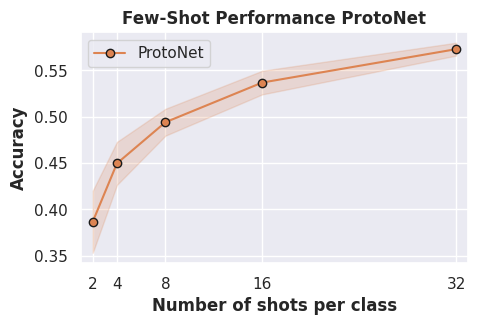

In [ ]:
ax = plot_few_shot(protonet_accuracies, name="ProtoNet", color="C1")
plt.show()
plt.close()

# Domain adaptation in the SVHN (1p)

So far, we have evaluated our meta-learning algorithms on the same dataset on which we have trained them. However, meta-learning algorithms are especially interesting when we want to move from one to another dataset. So, what happens if we apply them on a quite different dataset than CIFAR?

The Street View House Numbers (SVHN) dataset is a real-world image dataset for house number detection. It is similar to MNIST by having the classes 0 to 9, but is more difficult due to its real-world setting and possible distracting numbers left and right. Let's first load the dataset, and visualize some images to get an impression of the dataset.

In [ ]:
SVHN_test_dataset = SVHN(root=DATASET_PATH, split='test', download=True, transform=transforms.ToTensor())

100%|██████████| 64.3M/64.3M [00:40<00:00, 1.59MB/s]


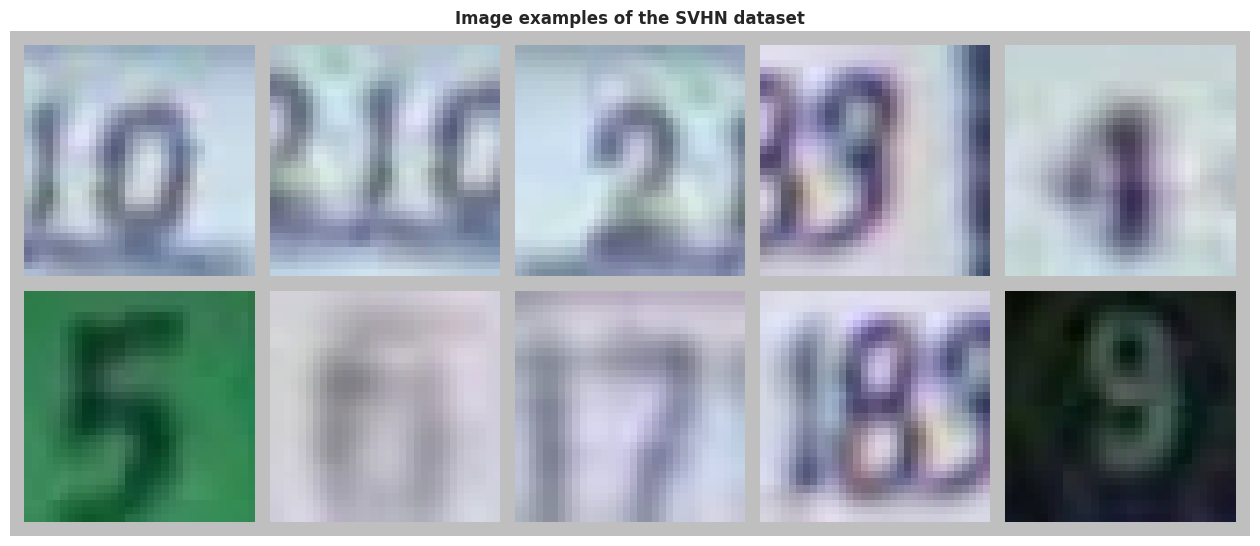

In [ ]:
# Visualize some examples
# TODO: Fill this #
NUM_CLASSES = 10
train_indices_per_class = {}

for c in range(NUM_CLASSES):
    train_indices_per_class[c] = torch.where(torch.tensor(SVHN_test_dataset.labels) == c)[0][0]

SVHN_images = torch.stack([SVHN_test_dataset[idx][0] for idx in train_indices_per_class.values()], dim=0)
img_grid = torchvision.utils.make_grid(
          SVHN_images,
          nrow=NUM_CLASSES // 2,
          normalize=True,
          pad_value=0.75
)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(16, 12))
plt.title("Image examples of the SVHN dataset", weight='bold')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

Each image is labeled with one class between 0 and 9 representing the main digit in the image. Can our ProtoNet learn to classify the digits from only a few examples? This is what we will test out below. The images have the same size as CIFAR, so that we can use the images without changes.

Prepare the dataset, for which we take the first 500 images per class. For this dataset, we use our test functions as before to get an estimated performance for different number of shots.

In [ ]:
# TODO: Prepare the Dataset in an ImageDataset class, limit number of examples to 500 to reduce test time #
test_transform = transforms.Compose([
                 transforms.ToTensor(),
                 transforms.Normalize(mean=torch.tensor([0.485, 0.456, 0.406]),
                                      std=torch.tensor([0.229, 0.224, 0.225]))
                 ])

images = np.transpose(SVHN_test_dataset.data, (0, 2, 3, 1))
targets = SVHN_test_dataset.labels
min_count = min(500, np.bincount(SVHN_test_dataset.labels).min())

idxs = np.concatenate([np.where(targets == c)[0][:min_count] for c in range(targets.max() + 1)], axis=0)
images = images[idxs]
targets_sub = torch.from_numpy(targets[idxs]).long()
svhn_fewshot_dataset = ImageDataset(images, targets_sub, img_transform=test_transform)

print(svhn_fewshot_dataset.imgs.shape)

(5000, 32, 32, 3)


### Experiments

First, we can apply ProtoNet to the SVHN dataset:

In [ ]:
# TODO: Fill this #
protonet_svhn_accuracies = dict()
data_feats = None
for k in [2, 4, 8, 16, 32]:
    protonet_svhn_accuracies[k], data_feats = test_proto_net(protonet_model, svhn_fewshot_dataset, data_feats=data_feats, k_shot=k)
    print(f"Accuracy for k={k}: {100.0 * protonet_svhn_accuracies[k][0]:4.2f}% (+-{100 * protonet_svhn_accuracies[k][1]:4.2f}%)")

Extracting features from images:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating prototype classification:   0%|          | 0/250 [00:00<?, ?it/s]

Accuracy for k=2: 13.15% (+-1.40%)


Evaluating prototype classification:   0%|          | 0/125 [00:00<?, ?it/s]

Accuracy for k=4: 17.64% (+-1.35%)


Evaluating prototype classification:   0%|          | 0/63 [00:00<?, ?it/s]

Accuracy for k=8: 21.66% (+-1.39%)


Evaluating prototype classification:   0%|          | 0/32 [00:00<?, ?it/s]

Accuracy for k=16: 26.17% (+-1.67%)


Evaluating prototype classification:   0%|          | 0/16 [00:00<?, ?it/s]

Accuracy for k=32: 29.52% (+-1.57%)


It becomes clear that the results are much lower than the ones on CIFAR, and just slightly above random for $k=2$.

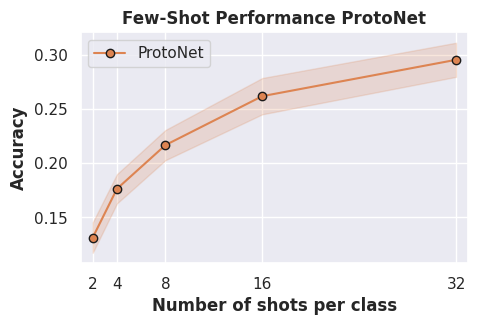

In [ ]:
ax = plot_few_shot(protonet_svhn_accuracies, name="ProtoNet", color="C1")
plt.show()
plt.close()

Repeat the experiments again by re-training on MNIST and testing on SVHN.
What do you expect in terms of performance?

Prototype networks trained on MNIST generalise poorly to SVHN compared to those trained on CIFAR. For this reason, we expect a worse result when the model is trained on the MNIST set. This is because the simple centred greyscale digits of MNIST are drastically different in terms of colour distribution, background complexity and noise from the real colour street view digits of SVHN, whereas CIFAR contains natural RGB images that are more similar to SVHN. In addition, the simplicity of ProtoNet causes the models to capture domain-specific shortcuts (e.g. dashed patterns, uniform backgrounds) in MNIST that do not carry over to the more nuanced semantics of SVHN. Training on CIFAR, on the other hand, promotes the learning of richer, colour- and texture-based features that better map to SVHN.

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 336kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.50MB/s]


Loaded pre-trained model for retrainin


Train Epoch 1:   0%|          | 0/1404 [00:00<?, ?it/s]

Val Epoch 1:   0%|          | 0/344 [00:00<?, ?it/s]

New best model saved with Accuracy on Validation Dataset: 0.9342
Epoch 1/20: Train Loss: 0.4978, Train Acc: 0.9699 | Val Loss: 0.5466, Val Acc: 0.9342


Train Epoch 2:   0%|          | 0/1404 [00:00<?, ?it/s]

Val Epoch 2:   0%|          | 0/344 [00:00<?, ?it/s]

New best model saved with Accuracy on Validation Dataset: 0.9404
Epoch 2/20: Train Loss: 0.4384, Train Acc: 0.9910 | Val Loss: 0.5176, Val Acc: 0.9404


Train Epoch 3:   0%|          | 0/1404 [00:00<?, ?it/s]

Val Epoch 3:   0%|          | 0/344 [00:00<?, ?it/s]

New best model saved with Accuracy on Validation Dataset: 0.9407
Epoch 3/20: Train Loss: 0.4274, Train Acc: 0.9932 | Val Loss: 0.5355, Val Acc: 0.9407


Train Epoch 4:   0%|          | 0/1404 [00:00<?, ?it/s]

Val Epoch 4:   0%|          | 0/344 [00:00<?, ?it/s]

New best model saved with Accuracy on Validation Dataset: 0.9448
Epoch 4/20: Train Loss: 0.4242, Train Acc: 0.9932 | Val Loss: 0.5267, Val Acc: 0.9448


Train Epoch 5:   0%|          | 0/1404 [00:00<?, ?it/s]

Val Epoch 5:   0%|          | 0/344 [00:00<?, ?it/s]

Epoch 5/20: Train Loss: 0.4187, Train Acc: 0.9947 | Val Loss: 0.5613, Val Acc: 0.9376


Train Epoch 6:   0%|          | 0/1404 [00:00<?, ?it/s]

Val Epoch 6:   0%|          | 0/344 [00:00<?, ?it/s]

Epoch 6/20: Train Loss: 0.4170, Train Acc: 0.9957 | Val Loss: 0.5554, Val Acc: 0.9217


Train Epoch 7:   0%|          | 0/1404 [00:00<?, ?it/s]

Val Epoch 7:   0%|          | 0/344 [00:00<?, ?it/s]

New best model saved with Accuracy on Validation Dataset: 0.9500
Epoch 7/20: Train Loss: 0.4199, Train Acc: 0.9951 | Val Loss: 0.4945, Val Acc: 0.9500


Train Epoch 8:   0%|          | 0/1404 [00:00<?, ?it/s]

Val Epoch 8:   0%|          | 0/344 [00:00<?, ?it/s]

Epoch 8/20: Train Loss: 0.4159, Train Acc: 0.9954 | Val Loss: 0.5409, Val Acc: 0.9311


Train Epoch 9:   0%|          | 0/1404 [00:00<?, ?it/s]

Val Epoch 9:   0%|          | 0/344 [00:00<?, ?it/s]

Epoch 9/20: Train Loss: 0.4161, Train Acc: 0.9953 | Val Loss: 0.5549, Val Acc: 0.9321


Train Epoch 10:   0%|          | 0/1404 [00:00<?, ?it/s]

Val Epoch 10:   0%|          | 0/344 [00:00<?, ?it/s]

Epoch 10/20: Train Loss: 0.4139, Train Acc: 0.9961 | Val Loss: 0.5248, Val Acc: 0.9453


Train Epoch 11:   0%|          | 0/1404 [00:00<?, ?it/s]

Val Epoch 11:   0%|          | 0/344 [00:00<?, ?it/s]

New best model saved with Accuracy on Validation Dataset: 0.9542
Epoch 11/20: Train Loss: 0.4150, Train Acc: 0.9957 | Val Loss: 0.5062, Val Acc: 0.9542


Train Epoch 12:   0%|          | 0/1404 [00:00<?, ?it/s]

Val Epoch 12:   0%|          | 0/344 [00:00<?, ?it/s]

New best model saved with Accuracy on Validation Dataset: 0.9552
Epoch 12/20: Train Loss: 0.4113, Train Acc: 0.9969 | Val Loss: 0.4728, Val Acc: 0.9552


Train Epoch 13:   0%|          | 0/1404 [00:00<?, ?it/s]

Val Epoch 13:   0%|          | 0/344 [00:00<?, ?it/s]

Epoch 13/20: Train Loss: 0.4112, Train Acc: 0.9967 | Val Loss: 0.5044, Val Acc: 0.9529


Train Epoch 14:   0%|          | 0/1404 [00:00<?, ?it/s]

Val Epoch 14:   0%|          | 0/344 [00:00<?, ?it/s]

Epoch 14/20: Train Loss: 0.4105, Train Acc: 0.9970 | Val Loss: 0.5078, Val Acc: 0.9471


Train Epoch 15:   0%|          | 0/1404 [00:00<?, ?it/s]

Val Epoch 15:   0%|          | 0/344 [00:00<?, ?it/s]

Epoch 15/20: Train Loss: 0.4141, Train Acc: 0.9961 | Val Loss: 0.5088, Val Acc: 0.9478


Train Epoch 16:   0%|          | 0/1404 [00:00<?, ?it/s]

Val Epoch 16:   0%|          | 0/344 [00:00<?, ?it/s]

Epoch 16/20: Train Loss: 0.4122, Train Acc: 0.9965 | Val Loss: 0.5172, Val Acc: 0.9398


Train Epoch 17:   0%|          | 0/1404 [00:00<?, ?it/s]

Val Epoch 17:   0%|          | 0/344 [00:00<?, ?it/s]

Epoch 17/20: Train Loss: 0.4099, Train Acc: 0.9967 | Val Loss: 0.5119, Val Acc: 0.9435


Train Epoch 18:   0%|          | 0/1404 [00:00<?, ?it/s]

Val Epoch 18:   0%|          | 0/344 [00:00<?, ?it/s]

Epoch 18/20: Train Loss: 0.4130, Train Acc: 0.9966 | Val Loss: 0.4968, Val Acc: 0.9545


Train Epoch 19:   0%|          | 0/1404 [00:00<?, ?it/s]

Val Epoch 19:   0%|          | 0/344 [00:00<?, ?it/s]

Epoch 19/20: Train Loss: 0.4115, Train Acc: 0.9964 | Val Loss: 0.4990, Val Acc: 0.9535


Train Epoch 20:   0%|          | 0/1404 [00:00<?, ?it/s]

Val Epoch 20:   0%|          | 0/344 [00:00<?, ?it/s]

Epoch 20/20: Train Loss: 0.4069, Train Acc: 0.9975 | Val Loss: 0.5589, Val Acc: 0.9391


Extracting features from images:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating prototype classification:   0%|          | 0/250 [00:00<?, ?it/s]

Accuracy for k=2: 11.05% (+-0.71%)


Evaluating prototype classification:   0%|          | 0/125 [00:00<?, ?it/s]

Accuracy for k=4: 11.41% (+-0.82%)


Evaluating prototype classification:   0%|          | 0/63 [00:00<?, ?it/s]

Accuracy for k=8: 11.96% (+-0.71%)


Evaluating prototype classification:   0%|          | 0/32 [00:00<?, ?it/s]

Accuracy for k=16: 12.64% (+-0.73%)


Evaluating prototype classification:   0%|          | 0/16 [00:00<?, ?it/s]

Accuracy for k=32: 13.75% (+-0.65%)


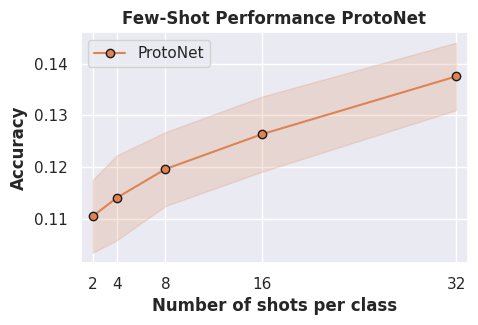

In [ ]:
# MNIST dataset
mnist_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(torch.tensor([0.1307, 0.1307, 0.1307]),
                         torch.tensor([0.3081, 0.3081, 0.3081])
    )
])

train_mnist = torchvision.datasets.MNIST(root="./data", train=True,  download=True)
test_mnist = torchvision.datasets.MNIST(root="./data", train=False, download=True)
train_imgs = np.stack([np.array(img) for img, _ in train_mnist], axis=0)
train_labels = np.array([label for _, label in train_mnist], dtype=int)
test_imgs = np.stack([np.array(img) for img, _ in test_mnist], axis=0)
test_labels = np.array([label for _, label in test_mnist], dtype=int)

all_imgs = np.concatenate([train_imgs, test_imgs], axis=0)
all_labels = torch.from_numpy(np.concatenate([train_labels, test_labels])).long()

mnist_dataset = ImageDataset(all_imgs, all_labels, img_transform=mnist_transform)
all_classes   = torch.unique(mnist_dataset.targets)
train_classes = all_classes[:8]
val_classes   = all_classes[8:10]

mnist_train_ds = dataset_from_labels(mnist_dataset.imgs,
                                     mnist_dataset.targets,
                                     train_classes,
                                     mnist_transform)
mnist_val_ds   = dataset_from_labels(mnist_dataset.imgs,
                                     mnist_dataset.targets,
                                     val_classes,
                                     mnist_transform)

mnist_train_loader = data.DataLoader(
                      mnist_train_ds,
                      batch_sampler=FewShotBatchSampler(
                          mnist_train_ds.targets,
                          include_query=True,
                          N_way=N_WAY,
                          K_shot=K_SHOT,
                          shuffle=True
                      ),
                      pin_memory=True,
                      persistent_workers=True,
                      num_workers=4
)

mnist_val_loader = data.DataLoader(
                    mnist_val_ds,
                    batch_sampler=FewShotBatchSampler(
                        mnist_val_ds.targets,
                        include_query=True,
                        N_way=N_WAY,
                        K_shot=K_SHOT,
                        shuffle=False,
                        shuffle_once=True
                    ),
                    pin_memory=True,
                    persistent_workers=True,
                    num_workers=4
)

protonet_model = train_model(ProtoNet,
                             proto_dim=64,
                             lr=1e-4,
                             train_loader=mnist_train_loader,
                             val_loader=mnist_val_loader,
                             kwargs={'load_model': True}
)

# Test on SVHN
protonet_svhn_accuracies = dict()
data_feats = None
for k in [2, 4, 8, 16, 32]:
    protonet_svhn_accuracies[k], data_feats = test_proto_net(protonet_model, svhn_fewshot_dataset, data_feats=data_feats, k_shot=k)
    print(f"Accuracy for k={k}: {100.0 * protonet_svhn_accuracies[k][0]:4.2f}% (+-{100 * protonet_svhn_accuracies[k][1]:4.2f}%)")

ax = plot_few_shot(protonet_svhn_accuracies, name="ProtoNet", color="C1")
plt.show()
plt.close()